In [320]:

import pandas as pd
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from datetime import date
import seaborn as sns


In [321]:
with open("raw_tables_2023_03_05/raw_tweets", "rb") as raw_timeline_file:
    tweet_df = pd.read_pickle(raw_timeline_file)
    # tweet_df.to_csv('raw_tweets_out.csv')


In [322]:
with open("raw_tables_2023_03_05/raw_user_profiles", "rb") as raw_timeline_file:
    user_df = pd.read_pickle(raw_timeline_file)
    # user_df.to_csv('raw_user_out.csv')
    

In [323]:
tweet_df.columns

Index(['id', 'url', 'user_name', 'content', 'creation_date', 'reply_count',
       'retweet_count', 'like_count', 'quote_count', 'view_count',
       'conversation_id', 'language', 'source', 'source_url', 'source_label',
       'links', 'media_types', 'reply_tweet_id', 'reply_user_name', 'hashtags',
       'cashtags', 'vibe_text', 'context_id', 'context_url',
       'context_user_name', 'context_content', 'context_creation_date',
       'context_reply_count', 'context_retweet_count', 'context_like_count',
       'context_quote_count', 'context_view_count', 'context_conversation_id',
       'context_language', 'context_source', 'context_source_url',
       'context_source_label', 'context_links', 'context_media_types',
       'context_reply_tweet_id', 'context_reply_user_name', 'context_hashtags',
       'context_cashtags', 'context_vibe_text', 'context_types'],
      dtype='object')

In [324]:
user_df.columns

Index(['user_name', 'display_name', 'description', 'description_links',
       'verification_status', 'creation_date', 'followers_count',
       'friends_count', 'statuses_count', 'favourites_count', 'listed_count',
       'media_count', 'location', 'protection_status', 'link'],
      dtype='object')

## Q.3
Are they equally active in using the Twitter platform to express their views?

No, There are a bunch of senators extremely active on Twitter, but majority of them have tweets between 0-5k


In [325]:
tweet_filtered = tweet_df.loc[tweet_df['reply_tweet_id'].isna()] #filter out LONG tweets that has to reply itself
total_tweets = len(tweet_filtered)
num_users = len(user_df)  # 583 == tweet_df['user_name'].nunique()


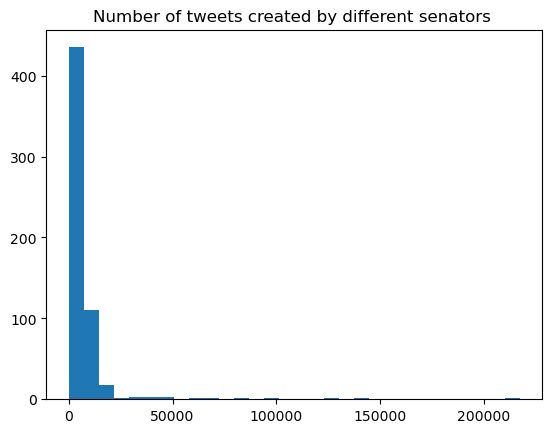

In [326]:
# Distribution of Number of tweets by different senators
plt.hist(tweet_filtered.groupby('user_name')[
         'id'].count(), density=False, bins=30);
plt.title('Number of tweets created by different senators ');


In [327]:
sortByCount = tweet_filtered.groupby('user_name')['id'].count().reset_index(
    name='count').sort_values(['count'],
                              ascending=False)  # sort user in descending order of their tweets amount
sum(sortByCount.head(int(num_users*0.1))
    ['count'])/total_tweets  # top 10% of senators created half of total tweets


0.4760794101648444

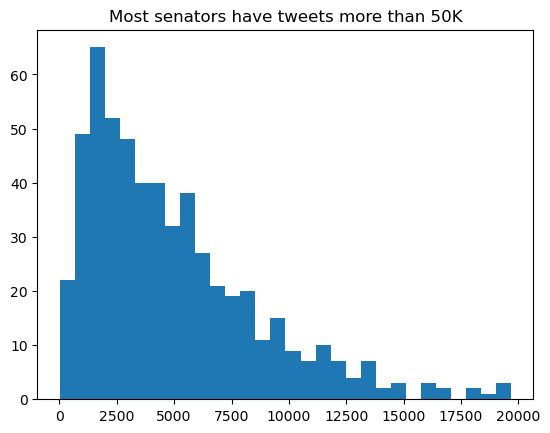

In [328]:
# Majority of senator have tweets around 2K.
plt.hist(sortByCount[sortByCount['count'] < 20000]
         ['count'], density=False, bins=30);
plt.title('Most senators have tweets more than 50K');


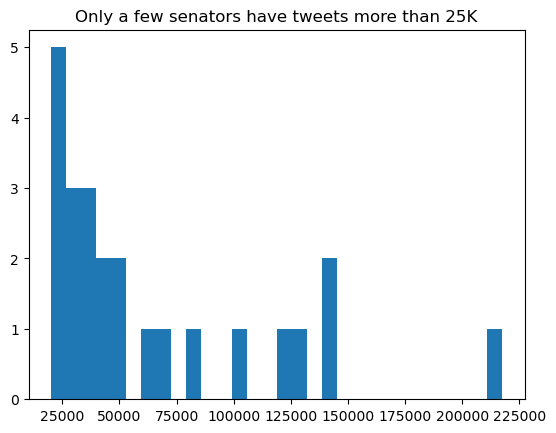

In [329]:
# There are a bunch of senators extremely active on Twitter
plt.hist(sortByCount[sortByCount['count'] >= 20000]['count'], density=False, bins=30);
plt.title('Only a few senators have tweets more than 25K') ;


In [330]:
# statistics of the Number of tweets by different senators
pd.options.display.float_format = '{:,.0f}'.format
sortByCount['count'].describe()


count       583
mean      7,395
std      16,124
min          25
25%       2,133
50%       4,301
75%       7,324
max     217,392
Name: count, dtype: float64

## Q6. Do they write tweets in similar length?


In [331]:
tweet_sampled = tweet_df.sample(frac = 0.05, replace=False) #randomly sample 5% of tweets

In [332]:
pattern = re.compile('http\S+')
def get_tweet_len(tweet):
    temp = pattern.sub(r'', tweet) #remove html in the tweet
    return len(word_tokenize(temp)) #count number of tokens in a tweet

tweet_sampled['tweet_len'] = tweet_sampled['content'].map(
    lambda x: get_tweet_len(x))

In [333]:
# combine tweets length:
temp1 = tweet_sampled[~tweet_sampled['reply_tweet_id'].isna()][[ 'reply_tweet_id', 'tweet_len']]
temp1.columns = ['reply_tweet_id_temp', 'tweet_len_temp']
temp2 = temp1.groupby(['reply_tweet_id_temp']).sum().reset_index()
combinedLen = pd.merge(temp2, tweet_sampled, how='right',
                       left_on='reply_tweet_id_temp', right_on='id')
combinedLen['tweet_len_temp'] = combinedLen['tweet_len_temp'].fillna(0)
combinedLen['total_tweet_len'] = combinedLen['tweet_len_temp']+combinedLen['tweet_len']
combinedLen.drop(
    ['reply_tweet_id_temp', 'tweet_len_temp'],
    axis=1, inplace=True)


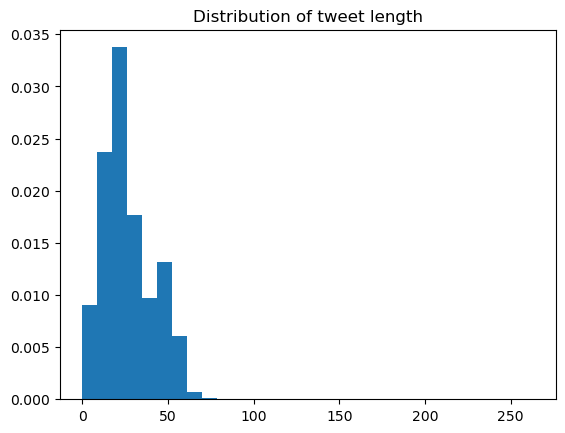

In [334]:
plt.hist(combinedLen['total_tweet_len'],density=True, bins=30);
plt.title('Distribution of tweet length');

## Q7. How many tweets do each person write in relation to the join date?


In [335]:
# calculate number of days since each senator joined Twitter
def getDays(x):
    date1 = x.date()
    date2 = date(2023, 3, 7)
    return (date2-date1).days


user_df['days_since_joined'] = user_df['creation_date'].map(
    lambda x: getDays(x))


In [336]:
days = pd.merge(sortByCount, user_df, on='user_name', how='inner')


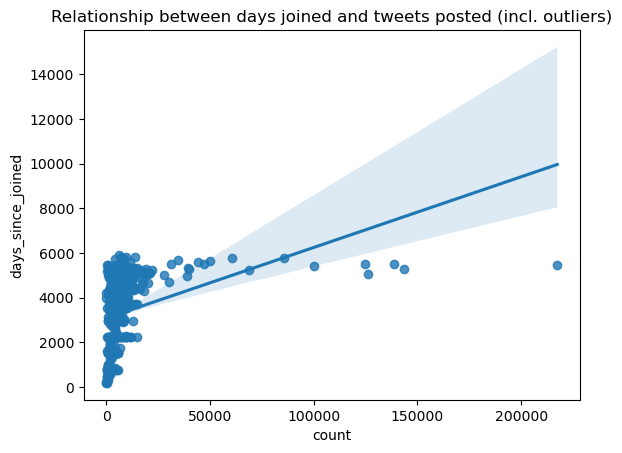

In [337]:
sns.regplot(data=days, x='count',
            y='days_since_joined', scatter=True)
plt.title('Relationship between days joined and tweets posted (incl. outliers)');


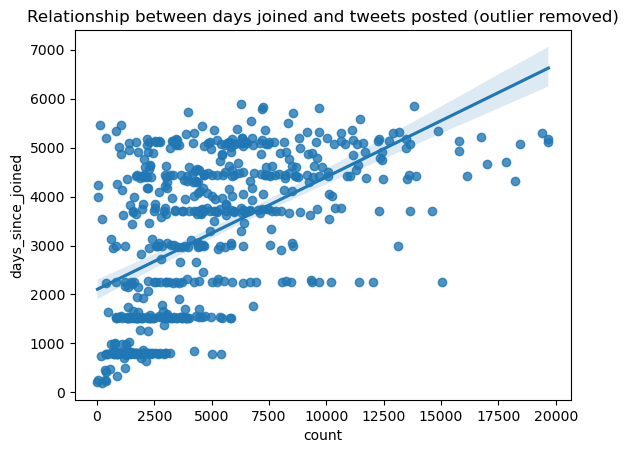

In [338]:
sns.regplot(data=days[days['count'] <=20000], x='count', y='days_since_joined', scatter=True);
plt.title('Relationship between days joined and tweets posted (outlier removed)');
